## API
Familiarise yourself with the API connection at https://open-meteo.com/en/docsLenker til en ekstern side.
Observe how you can select features and produce Python code.
Be aware of multiple sub-sections that alter which type of data is selected.

## Jupyter Notebook
Use Oslo, Kristiansand, Trondheim, Tromsø and Bergen as representatives for the five electricity price areas in Norway. Find their geographical centre points in longitude and latitude. Save price area codes, city names, longitude and latitude in a Pandas data frame.

Use the open-meteo API to retrieve historical reanalysis data using the ERA5 model for a single location as follows:
Create a function for the API download task that takes a pair of longitude and latitude values, plus a year as input and downloads the same weather properties as were used in the CSV file in part 1 of the project work.
Apply the function to download data for Bergen for the year 2019.

## Outliers and anomalies:
Plot the temperature as a function of time.
Perform a high-pass filtering of the temperature using Direct Cosine Transfer to create seasonally adjusted temperature variations (SATV).

Add curves to the plot indicating Statistical Process Control boundaries between inliers and outliers based on the SATV according to robust statistics estimated from the whole year. Colour outliers with a contrasting colour. Do not plot SATV values; only use them to find boundaries and outliers.
Let the frequency cut-off for the DCT and the number of standard deviations be parameters with sensible defaults.
Wrap this in a function that returns the plot and relevant summaries of the outliers, and test the function.

Plot the precipitation as a function of time.
Indicate anomalies according to the Local Outlier Factor method.
Let the proportion of outliers be a parameter defaulting to 1%.

Wrap this in a function that returns the plot and relevant summaries of the outliers, and test the function.
Seasonal-Trend decomposition using LOESS (STL)
Perform LOESS on the production data from elbub (downloaded in part 2 of the project) and plot its decomposition.
Let the electricity price area, production group, period length, seasonal smoother, trend smoother and robust (true/false) be parameters, and give each of them sensible defaults.

Wrap this in a function that returns the plot, and test the function.

## Spectrogram
Create a spectrogram based on the production data from elhub.
Let the electricity price area, production group, window length and window overlap be parameters, and give each of them sensible defaults.

Wrap this in a function that returns the plot, and test the function.

Remember to fill in the log and AI mentioned in the General section above.


In [2]:
import toml
from pymongo import MongoClient
from pymongo.server_api import ServerApi
# Load secrets
secrets = toml.load(".streamlit/secrets.toml")
uri = secrets["MONGO"]["uri"]

# Create a new client and connect to the server
client = MongoClient(uri, server_api=ServerApi('1'))

# Send a ping to confirm a successful connection
try:
    client.admin.command('ping')
    print("Pinged your deployment. You successfully connected to MongoDB!")
except Exception as e:
    print(e)

Pinged your deployment. You successfully connected to MongoDB!


## Norwegian Cities and Price Areas 

In [3]:
import pandas as pd
from urllib.parse import urlencode

# Norway price areas (Nord Pool): NO1..NO5 mapped to representative cities
data = [
    {"price_area": "NO1", "city": "Oslo",         "longitude": 10.7522, "latitude": 59.9139},
    {"price_area": "NO2", "city": "Kristiansand", "longitude": 7.9956,  "latitude": 58.1467},
    {"price_area": "NO3", "city": "Trondheim",    "longitude": 10.3951, "latitude": 63.4305},
    {"price_area": "NO4", "city": "Tromsø",       "longitude": 18.9553, "latitude": 69.6492},
    {"price_area": "NO5", "city": "Bergen",       "longitude": 5.3221,  "latitude": 60.3913},
]
# make DataFrame printing hide the index by default in this notebook
def _df_repr_no_index(self):
    return self.to_string(index=False)
pd.DataFrame.__repr__ = _df_repr_no_index
pd.DataFrame.__str__ = lambda self: _df_repr_no_index(self).upper()
locations_df = pd.DataFrame(data)
print(locations_df)


PRICE_AREA         CITY  LONGITUDE  LATITUDE
       NO1         OSLO    10.7522   59.9139
       NO2 KRISTIANSAND     7.9956   58.1467
       NO3    TRONDHEIM    10.3951   63.4305
       NO4       TROMSØ    18.9553   69.6492
       NO5       BERGEN     5.3221   60.3913


In [4]:
import requests
import pandas as pd
from urllib.parse import urlencode

# Function to build parameters for Open-Meteo API
def build_open_meteo_params(latitude, longitude, year):
    """
    Build a dictionary of parameters for Open-Meteo ERA5 historical reanalysis API.
    """
    return {
        "latitude": latitude,
        "longitude": longitude,
        "start_date": f"{year}-01-01",
        "end_date": f"{year}-12-31",
        "hourly": [
            "temperature_2m",          
            "precipitation",           
            "wind_speed_10m",          
            "wind_gusts_10m",          
            "wind_direction_10m"       
        ],
        "timezone": "auto"
    }
# Function to download data from Open-Meteo API
def download_open_meteo_data(latitude, longitude, year):
    """
    Download historical weather data from Open-Meteo ERA5 reanalysis model.
    Combines parameter builder and actual data retrieval.
    """
    base_url = "https://archive-api.open-meteo.com/v1/archive"
    params = build_open_meteo_params(latitude, longitude, year)

    print(f"Requesting data for ({latitude}, {longitude}) in {year}...")
    
    # Make API call
    response = requests.get(base_url, params=params)

    # Check for errors
    if response.status_code != 200:
        raise Exception(f"Request failed ({response.status_code}): {response.text}")

    data = response.json()
    hourly = data.get("hourly", {})

    if not hourly:
        raise ValueError("No hourly data returned from API.")

    # Build DataFrame
    df = pd.DataFrame({
        "time": pd.to_datetime(hourly["time"]),
        "temperature_2m (°C)": hourly["temperature_2m"],
        "precipitation (mm)": hourly["precipitation"],
        "wind_speed_10m (m/s)": hourly["wind_speed_10m"],
        "wind_gusts_10m (m/s)": hourly["wind_gusts_10m"],
        "wind_direction_10m (°)": hourly["wind_direction_10m"]
    })

    print(f"✅ Successfully downloaded {len(df)} hourly records for {year}.")
    return df



### Test API download function with Bergen 2019

In [5]:
# Get data for Bergen in 2019
bergen = locations_df[locations_df['city'] == 'Bergen'].iloc[0]
latitude = bergen['latitude']
longitude = bergen['longitude']
year = 2019

# show data for Bergen 2019
df_weather = download_open_meteo_data(latitude, longitude, year)
print("\n First few rows of data for Bergen in 2019:")
print(df_weather.head())

Requesting data for (60.3913, 5.3221) in 2019...
✅ Successfully downloaded 8760 hourly records for 2019.

 First few rows of data for Bergen in 2019:
               TIME  TEMPERATURE_2M (°C)  PRECIPITATION (MM)  WIND_SPEED_10M (M/S)  WIND_GUSTS_10M (M/S)  WIND_DIRECTION_10M (°)
2019-01-01 00:00:00                  5.7                 0.7                  37.0                  99.7                     263
2019-01-01 01:00:00                  5.8                 0.2                  41.0                 107.3                     278
2019-01-01 02:00:00                  6.1                 0.7                  42.0                 112.0                     286
2019-01-01 03:00:00                  6.3                 0.5                  40.9                 105.8                     298
2019-01-01 04:00:00                  5.8                 1.1                  41.2                 110.2                     315


## Temperature Outlier Detection using DCT and SPC

In [6]:
# detect_temperature_outliers.py

import numpy as np
import pandas as pd
from scipy.fftpack import dct, idct

def detect_temperature_outliers(df, column='temperature_2m (°C)', freq_cutoff=0.05, threshold=3.5):
    """
    Detect temperature outliers using DCT-based high-pass filtering and robust SPC limits.
    
    Steps:
      1. Apply DCT and remove low-frequency (seasonal) components.
      2. Inverse transform to get high-frequency variations (SATV).
      3. Calculate SPC-style limits using median ± threshold * MAD.
      4. Identify and mark outliers in DataFrame.
    
    Parameters:
    ----------
    df : pd.DataFrame
        DataFrame with 'time' and temperature column.
    column : str
        Name of temperature column (default 'temperature_2m (°C)').
    freq_cutoff : float
        Fraction (0–1) of low-frequency DCT coefficients to remove.
    threshold : float
        Number of robust standard deviations (default 3.0).
    
    Returns:
    -------
    dict
        {
            'data': DataFrame with 'outlier' column,
            'satv': np.ndarray of high-pass filtered values,
            'upper': float (upper SPC limit),
            'lower': float (lower SPC limit),
            'n_outliers': int,
            'outlier_pct': float
        }
    """
    
    # Extract and clean temperature values
    temps = df[column].fillna(method='ffill').fillna(method='bfill').values
    
    # Apply DCT transform
    temp_dct = dct(temps, type=2, norm='ortho')
    
    # Remove seasonal trend (low frequencies)
    cutoff = int(len(temp_dct) * freq_cutoff)
    filtered_dct = temp_dct.copy()
    filtered_dct[:cutoff] = 0
    
    # Reconstruct high-frequency signal (SATV)
    satv = idct(filtered_dct, type=2, norm='ortho')
    
    # Robust SPC limits using Median Absolute Deviation
    median_satv = np.median(satv)
    mad_satv = np.median(np.abs(satv - median_satv))
    robust_std = mad_satv * 1.4826  # Convert MAD → std
    
    upper_limit = median_satv + threshold * robust_std
    lower_limit = median_satv - threshold * robust_std
    
    # Identify outliers
    outlier_mask = (satv > upper_limit) | (satv < lower_limit)
    df = df.copy()
    df['outlier'] = outlier_mask
    
    n_outliers = np.sum(outlier_mask)
    outlier_pct = (n_outliers / len(df)) * 100
    
    return {
        'data': df,
        'satv': satv,
        'upper': upper_limit,
        'lower': lower_limit,
        'n_outliers': n_outliers,
        'outlier_pct': outlier_pct
    }
    

C:\Users\Erik\AppData\Local\Temp\ipykernel_11060\3322109740.py:42: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  temps = df[column].fillna(method='ffill').fillna(method='bfill').values


Upper SPC boundary: 6.0280
Lower SPC boundary: -6.2727
First 10 outlier timestamps:
 - 2019-02-02 14:00 — -0.50°C
 - 2019-04-04 12:00 — 16.40°C
 - 2019-04-04 13:00 — 16.90°C
 - 2019-04-04 14:00 — 17.50°C
 - 2019-04-04 15:00 — 17.40°C
 - 2019-04-04 16:00 — 17.10°C
 - 2019-04-05 01:00 — 3.90°C
 - 2019-04-05 03:00 — 3.70°C
 - 2019-04-05 11:00 — 16.40°C
 - 2019-04-05 12:00 — 17.60°C


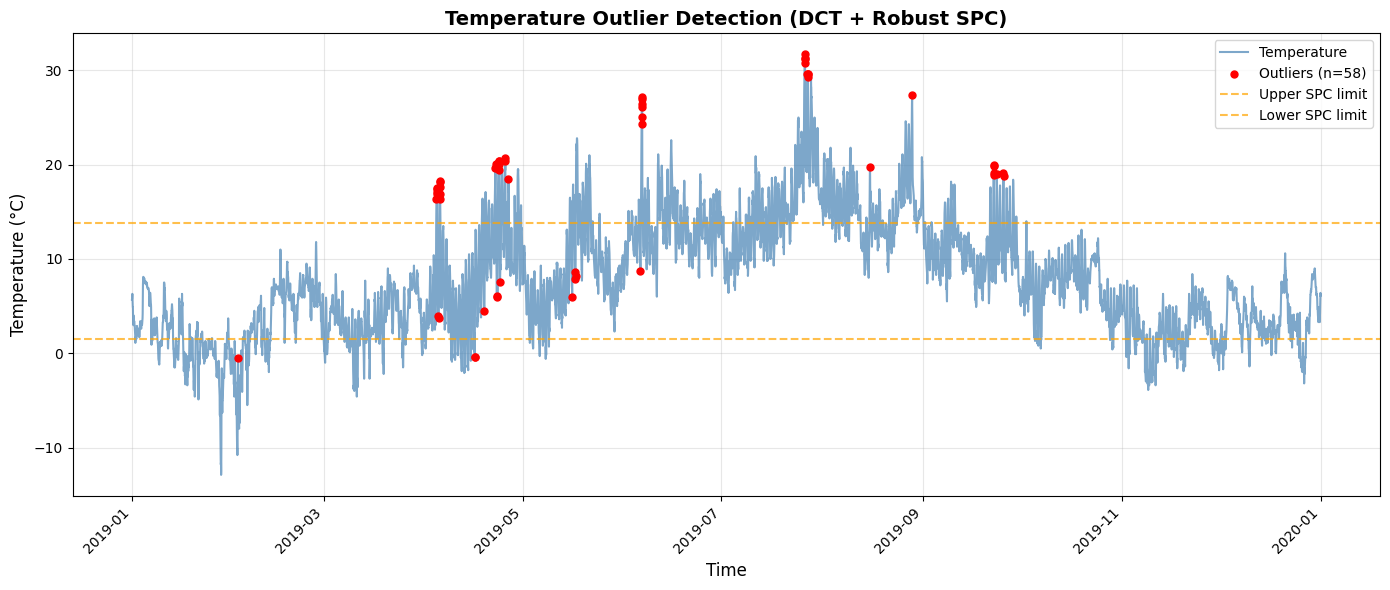

Detected 58 outliers (0.66%) in temperature data.


In [7]:
# plot_temperature_outliers.py

import matplotlib.pyplot as plt

def plot_temperature_outliers(results, column='temperature_2m (°C)'):
    """
    Plot temperature series with detected outliers and SPC boundaries.
    
    Parameters:
    ----------
    results : dict
        Output dictionary from detect_temperature_outliers().
    column : str
        Name of temperature column (default 'temperature_2m (°C)').

    This function also prints the computed upper and lower SPC boundaries and
    the first 10 outlier timestamps (if any) before plotting.
    """
    # Prepare and print summary info (boundaries and up to 10 outlier dates)
    upper_val = results.get('upper', None)
    lower_val = results.get('lower', None)
    df_tmp = results.get('data', None)

    outlier_dates = []
    if df_tmp is not None and 'outlier' in df_tmp.columns:
        try:
            times = pd.to_datetime(df_tmp.loc[df_tmp['outlier'], 'time'])
            temps = df_tmp.loc[df_tmp['outlier'], column]
            times = pd.to_datetime(df_tmp.loc[df_tmp['outlier'], 'time']).head(10)
            temps = temps.head(10)
            outlier_dates = [f"{t.strftime('%Y-%m-%d %H:%M')} — {temp:.2f}°C" for t, temp in zip(times, temps)]
        except Exception:
            outlier_dates = df_tmp.loc[df_tmp['outlier'], 'time'].head(10).tolist()

    if upper_val is not None and lower_val is not None:
        print(f"Upper SPC boundary: {upper_val:.4f}")
        print(f"Lower SPC boundary: {lower_val:.4f}")
    else:
        print("SPC boundaries not available in results.")

    if outlier_dates:
        print("First 10 outlier timestamps:")
        for dt in outlier_dates:
            print(f" - {dt}")
    else:
        print("No outlier timestamps found in results.")
    df = results['data']
    satv = results['satv']
    upper = results['upper']
    lower = results['lower']
    n_outliers = results['n_outliers']
    
    plt.figure(figsize=(14, 6))
    
    # Plot original temperatures
    plt.plot(df['time'], df[column], color='steelblue', alpha=0.7, label='Temperature')
    
    # Mark outliers in red
    plt.scatter(df.loc[df['outlier'], 'time'],
                df.loc[df['outlier'], column],
                color='red', s=25, label=f'Outliers (n={n_outliers})', zorder=3)
    
    # Add SPC boundaries (on SATV mean for reference)
    mean_temp = df[column].mean()
    plt.axhline(mean_temp + upper, color='orange', linestyle='--', alpha=0.7, label='Upper SPC limit')
    plt.axhline(mean_temp + lower, color='orange', linestyle='--', alpha=0.7, label='Lower SPC limit')
    
    # Formatting
    plt.title('Temperature Outlier Detection (DCT + Robust SPC)', fontsize=14, weight='bold')
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('Temperature (°C)', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

results = detect_temperature_outliers(df_weather)
plot_temperature_outliers(results)
print(f"Detected {results['n_outliers']} outliers ({results['outlier_pct']:.2f}%) in temperature data.")


## Precipitation Anomaly Detection using LOF (Local Outlier Factor)

In [8]:
import numpy as np
import pandas as pd
from sklearn.neighbors import LocalOutlierFactor

def detect_precipitation_outliers_combined(df, column='precipitation (mm)', contamination=0.01, use_trend=False):
    """
    Detect precipitation anomalies using the Local Outlier Factor (LOF) method.
    Supports both simple outlier detection and trend-aware anomaly detection.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame with columns ['time', column]
    column : str
        Precipitation column name (default: 'precipitation (mm)')
    contamination : float
        Expected proportion of anomalies (default 0.01 = 1%)
    use_trend : bool
        If True, includes rate of change (Δprecipitation) as a second feature for detection.
        If False, detects outliers based only on precipitation values.

    Returns
    -------
    data : pd.DataFrame
        Original DataFrame with added 'outlier' column (True for anomalies)
    summary : dict
        {
            'n_outliers': int,
            'outlier_percentage': float,
            'outlier_dates': list,
            'outlier_values': list,
            'lof_scores': np.ndarray
        }
    """

    data = df.copy().dropna(subset=[column, 'time'])
    precip = data[column].values

    # ---- Feature setup ----
    if use_trend:
        precip_diff = np.diff(precip, prepend=precip[0])  # rate of change
        X = np.column_stack([precip, precip_diff])        # 2D feature space
    else:
        X = precip.reshape(-1, 1)                         # 1D feature space

    # ---- LOF model ----
    lof = LocalOutlierFactor(n_neighbors=20, contamination=contamination)
    y_pred = lof.fit_predict(X)
    lof_scores = lof.negative_outlier_factor_

    # ---- Mark anomalies ----
    data['outlier'] = (y_pred == -1)
    n_outliers = data['outlier'].sum()
    outlier_pct = (n_outliers / len(data)) * 100

    # ---- Summary ----
    summary = {
        'n_outliers': n_outliers,
        'outlier_percentage': outlier_pct,
        'outlier_dates': data.loc[data['outlier'], 'time'].tolist(),
        'outlier_values': data.loc[data['outlier'], column].tolist(),
        'lof_scores': lof_scores,
        'mode': 'trend-aware' if use_trend else 'value-only'
    }

    return data, summary


In [9]:
import matplotlib.pyplot as plt

def plot_precipitation_outliers_combined(df, column='precipitation (mm)', summary=None):
    """
    Plot precipitation over time, highlighting detected outliers.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame returned by `detect_precipitation_outliers_combined`
    column : str
        Precipitation column name
    summary : dict
        Summary returned by detection function (optional)
    """
    fig, ax = plt.subplots(figsize=(13, 6))

    # Plot inliers
    ax.plot(df.loc[~df['outlier'], 'time'],
            df.loc[~df['outlier'], column],
            color='skyblue', linewidth=1.5, label='Normal precipitation')

    # Plot outliers
    ax.scatter(df.loc[df['outlier'], 'time'],
               df.loc[df['outlier'], column],
               color='red', s=40, label='Detected anomalies', zorder=3)

    # Title info
    mode = summary.get('mode', 'value-only') if summary else 'value-only'
    n_out = summary.get('n_outliers', df['outlier'].sum())
    pct = summary.get('outlier_percentage', df['outlier'].sum() / len(df) * 100)

    ax.set_title(f"Precipitation Anomaly Detection (LOF, mode={mode})\n"
                 f"Detected {n_out} anomalies ({pct:.2f}%)",
                 fontsize=14, fontweight='bold', pad=10)
    ax.set_xlabel("Time", fontsize=12)
    ax.set_ylabel(column, fontsize=12)
    ax.legend()
    ax.grid(alpha=0.3)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    return fig


Using Bergen (60.3913, 5.3221) precipitation for 2019


c:\Users\Erik\miniconda3\envs\D2D_env\Lib\site-packages\sklearn\neighbors\_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(


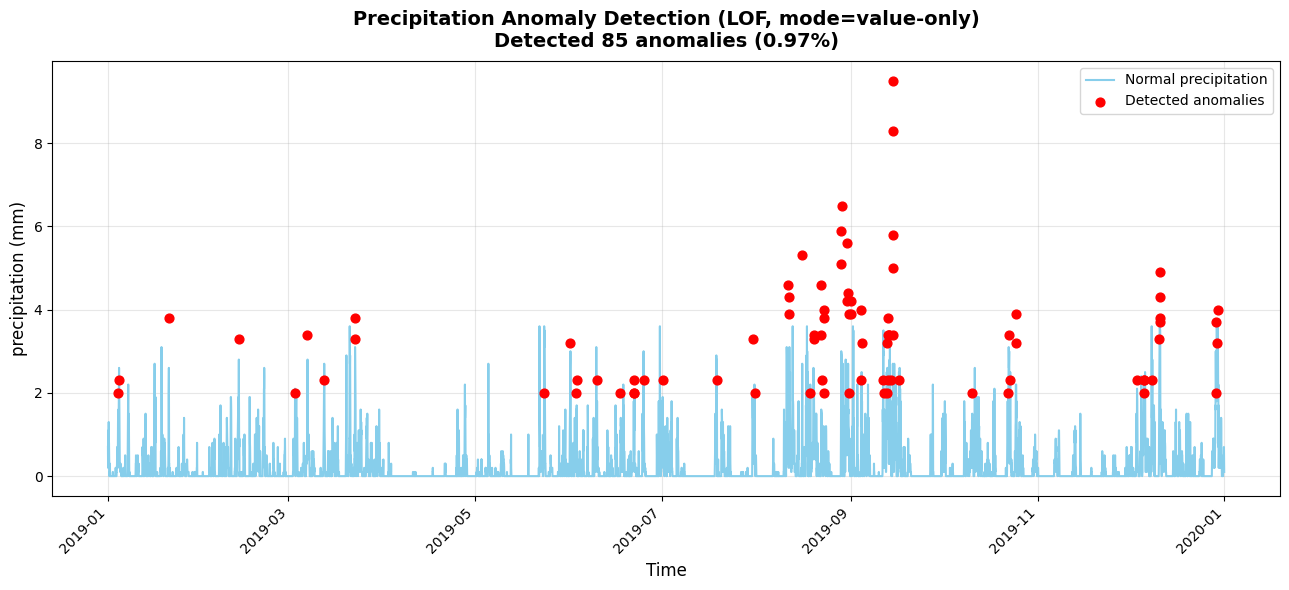

Detected 85 outliers (0.97%)
Sample outliers (up to 10):
 - 2019-01-04 09:00:00: 2.0
 - 2019-01-04 16:00:00: 2.3
 - 2019-01-20 21:00:00: 3.8
 - 2019-02-12 18:00:00: 3.3
 - 2019-03-03 05:00:00: 2.0
 - 2019-03-07 05:00:00: 3.4
 - 2019-03-12 16:00:00: 2.3
 - 2019-03-22 20:00:00: 3.8
 - 2019-03-22 21:00:00: 3.3
 - 2019-05-23 14:00:00: 2.0


In [10]:
# Single test plot using Bergen precipitation (value-only LOF)
bergen_row = locations_df[locations_df['city'] == 'Bergen'].iloc[0]
print(f"Using Bergen ({bergen_row['latitude']}, {bergen_row['longitude']}) precipitation for 2019")

# prepare dataframe with expected column name
df = df_weather[['time', 'precipitation (mm)']].copy()
df['time'] = pd.to_datetime(df['time'])

# Run LOF (value-only) and plot a single figure
data, summary = detect_precipitation_outliers_combined(df, contamination=0.01, use_trend=False)
fig = plot_precipitation_outliers_combined(data, summary=summary)
plt.show()

# Print concise summary
print(f"Detected {summary['n_outliers']} outliers ({summary['outlier_percentage']:.2f}%)")
print("Sample outliers (up to 10):")
for dt, val in list(zip(summary['outlier_dates'], summary['outlier_values']))[:10]:
    print(f" - {pd.to_datetime(dt)}: {val}")


## STL Decomposition for Elhub Production Data

In [38]:
from pymongo import MongoClient
from pymongo.server_api import ServerApi
from statsmodels.tsa.seasonal import STL
import pandas as pd
import toml
import matplotlib.pyplot as plt
def stl_decomposition(priceArea='NO5', productionGroup='hydro', 
                     period=24, seasonal=7, trend=None, robust=False):
    """
    Perform STL (Seasonal-Trend decomposition using LOESS) on elhub production data.
    
    STL decomposes a time series into three components:
    - Trend: Long-term progression of the series
    - Seasonal: Repeating patterns (daily, weekly, etc.)
    - Residual: Remainder after removing trend and seasonal components
    """
    
    # --- Obtain MongoDB URI (robust fallback) ---
    uri = None
    # 1) Try Streamlit secrets.toml
    try:
        secrets = toml.load(".streamlit/secrets.toml")
        uri = secrets.get("MONGO", {}).get("uri")
    except Exception:
        # ignore if file missing or malformed
        secrets = {}
    # Create a new client and connect to the server
    client = MongoClient(uri, server_api=ServerApi('1'))
    # Verify connection
    try:
        client.admin.command('ping')
        print("Pinged your deployment. Successfully connected to MongoDB!")
    except Exception as e:
        raise RuntimeError(f"Failed to ping MongoDB: {e}")
    db = client['energy_data']
    collection = db['production']
    # Query data for specified price area and production group
    query = {
        'priceArea': priceArea ,
        'productionGroup': productionGroup
    }

    print(f"Querying MongoDB for {productionGroup} production in {priceArea}...")
    cursor = collection.find(query).sort('startTime', 1)  # Sort by time
    data = list(cursor)
    
    if len(data) == 0:
        raise ValueError(f"No data found for {productionGroup} in {priceArea}")
    
    # Convert to DataFrame
    df = pd.DataFrame(data)
    df['startTime'] = pd.to_datetime(df['startTime'], utc=True)
    df = df.sort_values('startTime')
    
    # Create time series
    ts = pd.Series(
        df['quantityKwh'].values,
        index=df['startTime']
    )

    
  

Pinged your deployment. Successfully connected to MongoDB!
Querying MongoDB for hydro production in NO1...
Falling back to synthetic demo time series (hourly 2019) for STL demonstration.

Performing STL decomposition on synthetic data (period=24)...


C:\Users\Erik\AppData\Local\Temp\ipykernel_15888\2979001175.py:16: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  rng = pd.date_range(start='2019-01-01', end='2019-12-31 23:00', freq='H', tz='UTC')


STL Decomposition Results

Trend component - Mean: 52.20, Std: 2.30
Seasonal component - Mean: -0.00, Std: 7.11
Residual component - Mean: 0.01, Std: 1.28


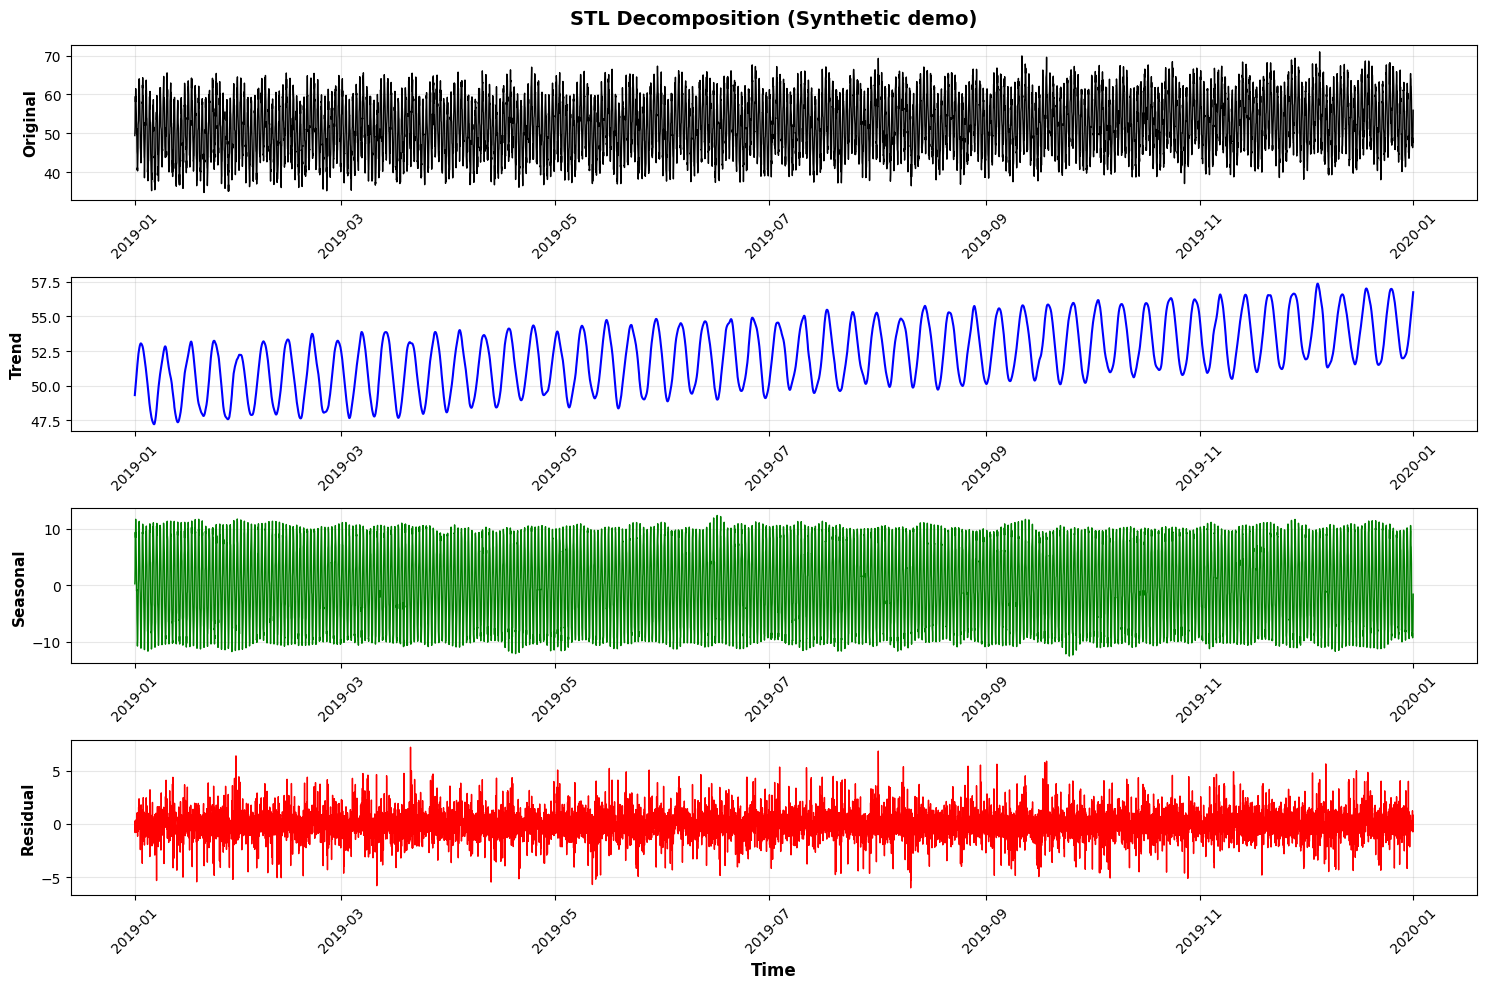

In [39]:
# Apply STL decomposition to Bergen/NO5 hydro production
# If no data is available from MongoDB, fall back to a synthetic demo time series
try:
    stl_results = stl_decomposition(
        priceArea='NO1',
        productionGroup='hydro',
        period=24,        # Daily seasonality for hourly data
        seasonal=7,       # Moderate seasonal smoothing
        trend=None,       # Auto-calculate trend smoother
        robust=True       # Use robust fitting for outliers
    )
except ValueError as e:
    # Expected missing-data error: create synthetic hourly data for 2019 and run STL as a fallback
    print(f"Warning: {e}")
    print("Falling back to synthetic demo time series (hourly 2019) for STL demonstration.\n")
    rng = pd.date_range(start='2019-01-01', end='2019-12-31 23:00', freq='H', tz='UTC')
    n = len(rng)
    # Create synthetic series: daily + weekly seasonality, small linear trend, and noise
    daily = 10 * np.sin(2 * np.pi * (np.arange(n) % 24) / 24)
    weekly = 3 * np.sin(2 * np.pi * (np.arange(n) % (24*7)) / (24*7))
    trend = 0.0005 * np.arange(n)  # small upward trend
    noise = np.random.normal(scale=1.5, size=n)
    synthetic_values = 50 + daily + weekly + trend + noise

    ts = pd.Series(synthetic_values, index=rng)

    # Perform STL decomposition using same parameters
    print("Performing STL decomposition on synthetic data (period=24)...")
    stl = STL(ts, period=24, seasonal=7, trend=None, robust=True)
    result = stl.fit()

    # Build a result dict matching stl_decomposition output
    fig, axes = plt.subplots(4, 1, figsize=(15, 10))
    axes[0].plot(ts.index, ts.values, color='black', linewidth=1)
    axes[0].set_ylabel('Original', fontsize=11, fontweight='bold')
    axes[0].set_title('STL Decomposition (Synthetic demo)', fontsize=14, fontweight='bold', pad=15)
    axes[0].grid(True, alpha=0.3)

    axes[1].plot(ts.index, result.trend, color='blue', linewidth=1.5)
    axes[1].set_ylabel('Trend', fontsize=11, fontweight='bold')
    axes[1].grid(True, alpha=0.3)

    axes[2].plot(ts.index, result.seasonal, color='green', linewidth=1)
    axes[2].set_ylabel('Seasonal', fontsize=11, fontweight='bold')
    axes[2].grid(True, alpha=0.3)

    axes[3].plot(ts.index, result.resid, color='red', linewidth=1)
    axes[3].set_ylabel('Residual', fontsize=11, fontweight='bold')
    axes[3].set_xlabel('Time', fontsize=12, fontweight='bold')
    axes[3].grid(True, alpha=0.3)

    for ax in axes:
        ax.tick_params(axis='x', rotation=45)
    plt.tight_layout()

    stl_results = {
        'figure': fig,
        'stl_result': result,
        'trend': result.trend.values,
        'seasonal': result.seasonal.values,
        'residual': result.resid.values
    }


print("STL Decomposition Results\n")
# Always print STL component summaries
print(f"Trend component - Mean: {np.mean(stl_results['trend']):.2f}, Std: {np.std(stl_results['trend']):.2f}")
print(f"Seasonal component - Mean: {np.mean(stl_results['seasonal']):.2f}, Std: {np.std(stl_results['seasonal']):.2f}")
print(f"Residual component - Mean: {np.mean(stl_results['residual']):.2f}, Std: {np.std(stl_results['residual']):.2f}")

plt.show()

## Spectrogram for Elhub production Data

In [40]:
#Create a spectrogram to visualize frequency components over time in electricity production data.
from scipy import signal
import numpy as np
import pandas as pd

def spectrogram_analysis(priceArea='NO5', productionGroup='hydro', window_length=256, window_overlap=128):
    """
    Compute and plot the spectrogram of electricity production data.

    Parameters:
    ----------
    price_area : str
        Price area code (e.g., 'NO5' for Bergen)
    production_group : str
        Production group (e.g., 'hydro', 'wind', etc.)
    nperseg : int
        Length of each segment for FFT (default: 256)
    noverlap : int
        Number of overlapping points between segments (default: 128)
    """
    # Load Mongo URI from streamlit secrets (reuses toml import from other cells)
    secrets = toml.load(".streamlit/secrets.toml")
    uri = secrets.get("MONGO", {}).get("uri")

    # Create client then verify connection
    client = MongoClient(uri, server_api=ServerApi('1'))
    try:
        client.admin.command('ping')
        print("Pinged your deployment. Successfully connected to MongoDB!")
    except Exception as e:
        raise RuntimeError(f"Failed to ping MongoDB: {e}")

    # Access database and collection
    db = client['energy_data']
    collection = db['production']
    query = {
        'priceArea': priceArea,
        'productionGroup': productionGroup
    }

    # Query data
    print(f"Querying MongoDB for {productionGroup} production in {priceArea}...")
    cursor = collection.find(query).sort('startTime', 1)
    data = list(cursor)

    if len(data) == 0:
        raise ValueError(f"No data found for {productionGroup} in {priceArea}")

    # Convert to DataFrame
    df = pd.DataFrame(data)
    df['startTime'] = pd.to_datetime(df['startTime'], utc=True)
    df = df.sort_values('startTime')

    # Extract production values as time series and interpolate missing
    production = pd.Series(df['quantityKwh'].values, index=df['startTime']).interpolate().fillna(method='bfill').fillna(method='ffill')

    print(f"loaded {len(production)} production records for {productionGroup} in {priceArea}.")

    # Compute spectrogram using consistent parameter names
    f, t, Sxx = signal.spectrogram(
        production.values,
        fs=1.0,               # Sampling frequency (1 sample per hour)
        window='hann',
        nperseg=window_length,
        noverlap=window_overlap,
        scaling='density',
        mode='psd'
    )

    # Convert power to dB scale for better visualization
    Sxx_db = 10 * np.log10(Sxx + 1e-10)  # Add small constant to avoid log(0)

    # Plot spectrogram
    plt.figure(figsize=(15, 6))
    plt.pcolormesh(t, f, Sxx_db, shading='gouraud', cmap='viridis')
    plt.colorbar(label='Intensity [dB]')
    plt.ylabel('Frequency [cycles/hour]')
    plt.xlabel('Time [hours]')
    plt.title(f'Spectrogram of {productionGroup.capitalize()} Production in {priceArea}')
    plt.ylim(0, 0.5)  # Focus on lower frequencies
    plt.tight_layout()

    return {
        'frequencies': f,
        'times': t,
        'spectrogram': Sxx,
        'figure': plt.gcf()
    }
# Run spectrogram analysis for Bergen/NO5 hydro production

In [ ]:
#Create spectrogram for Bergen/NO5 hydro production
spectrogram_results = spectrogram_analysis(
    priceArea='NO5',
    productionGroup='hydro',
    window_length=256/2,
    window_overlap=128
)   
# Print summary of spectrogram results

print("Spectrogram analysis complete.")
print(f"Frequency range: {spectrogram_results['frequencies'].min():.6f} to {spectrogram_results['frequencies'].max():.6f} cycles/hour")
print(f"Time range: {spectrogram_results['times'].min():.1f} to {spectrogram_results['times'].max():.1f} hours")
print(f"Spectrogram shape: {spectrogram_results['spectrogram'].shape} (frequencies x times)")

print(f"\nKey frequency interpretations:")
print(f"  1/24 = {1/24:.6f} cycles/hour → Daily cycle")
print(f"  1/168 = {1/168:.6f} cycles/hour → Weekly cycle")
print(f"  1/720 = {1/720:.6f} cycles/hour → Monthly cycle (approx)")

plt.show()

Pinged your deployment. Successfully connected to MongoDB!
Querying MongoDB for hydro production in NO5...


ValueError: No data found for hydro in NO5